In [19]:
import transformers
from transformers import GPT2Config, GPT2LMHeadModel
import pickle
import torch
import torch.nn as nn
import time
import matplotlib.pyplot as plt
import numpy as np
from tqdm.autonotebook import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
with open("data/preprocessed/100k/vocab.pkl", "rb") as f:
    vocab, itos, stoi = pickle.load(f)

space_idx = stoi[" "]

In [3]:
# Comes from data preprocessing
bptt = 256
def load_data(path):
    x = torch.load(path+'_x.pt')
    y = torch.load(path+'_y.pt')
    lens = torch.load(path+'_lens.pt')

    idx = torch.cat([torch.tensor([0]), torch.cumsum(lens, 0)])

    y = [y[idx[i]:idx[i+1]].to(device) for i in range(len(idx)-1)]

    return x.to(device), y

X_train, Y_train = load_data("data/preprocessed/100k/train")
X_valid, Y_valid = load_data("data/preprocessed/100k/valid")
X_test, Y_test = load_data("data/preprocessed/100k/test")

bs = 32

# Precompute Y_batches given bs
Y_batched = []
for i in range(0, len(Y_train), bs):
    Y_batched.append(torch.cat(Y_train[i:i+bs], axis=0))

Y_val_batched = []
for i in range(0, len(Y_valid), bs):
    Y_val_batched.append(torch.cat(Y_valid[i:i+bs], axis=0))

In [4]:
def board_train(model, optimizer, X, Y_batched, verbose=True, log=[]):

    criterion = nn.CrossEntropyLoss()

    total_loss = 0.
    total_p_acc = 0.
    total_b_acc = 0.
    start_time = time.time()

    for i in range(0, len(X), bs):
        batch = i//bs+1

        X_batch = X[i:i+bs]
        spaces = torch.where(X_batch == stoi[" "])
        
        Y_batch = Y_batched[i//bs]
        
        # Fucking kill me.  Torch expects bptt dim first instead of batch
        output = model(X_batch).logits.view(-1, bptt, 8, 8, 13)

        y_pred = output[spaces[0], spaces[1]]

        loss = criterion(y_pred.view(-1, 13), Y_batch.view(-1))

        equal = (y_pred.argmax(-1) == Y_batch)

        piece_acc = equal.float().mean().item()
        board_acc = equal.all(-1).all(-1).float().mean().item()

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        total_p_acc += piece_acc
        total_b_acc += board_acc

        ms_per_batch = (time.time() - start_time) * 1000 / batch
        cur_loss = total_loss / batch
        cur_p_acc = total_p_acc / batch
        cur_b_acc = total_b_acc / batch

        if verbose:
            print(f'| {batch:5d}/{len(X_train)//bs+1:5d} batches | '
                    f'ms/batch {ms_per_batch:5.2f} | '
                    f'loss {cur_loss:5.2f} | piece acc {cur_p_acc:5.2f} | board acc {cur_b_acc:5.2f} ', end="\r")
        
        log.append({"loss":loss.item(), "piece_acc":piece_acc, "board_acc":board_acc})

    if verbose:
        print()

    return log

In [8]:
def ntp_train(model, optimizer, X, verbose=True, log=[]):
    criterion = nn.CrossEntropyLoss()
    bar = tqdm(range(0, len(X), bs))

    for i in bar:
        X_batch = X[i:i+bs, :-1]
        Y_batch = X[i:i+bs, 1:]
        
        y_pred = torch.swapaxes(model(X_batch).logits, -1, -2)

        # print(y_pred.shape, Y_batch.shape)

        loss = criterion(y_pred, Y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        bar.set_postfix({"loss":loss.item()})

        log.append(loss.item())

    return log

In [9]:
def create_model(config, verbose=True):
    model = GPT2LMHeadModel(config)
    if verbose:
        print(f"Parameter count: {sum(p.numel() for p in model.parameters())/1e6:.1f}M")
    return model.to(device)

In [10]:
config = GPT2Config(
    vocab_size=len(vocab),
    n_layer=4,
    n_head=4,
    n_embd=256,
    resid_pdrop=0,
    embd_pdrop=0,
    attn_pdrop=0,
)

model = create_model(config)

epochs = 10

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

log = []

for epoch in range(1, 1+epochs):
    log = ntp_train(model, optimizer, X_train, verbose=False, log=log)

Parameter count: 3.4M


 45%|████▌     | 1282/2844 [00:55<01:07, 23.15it/s, loss=0.528]


KeyboardInterrupt: 

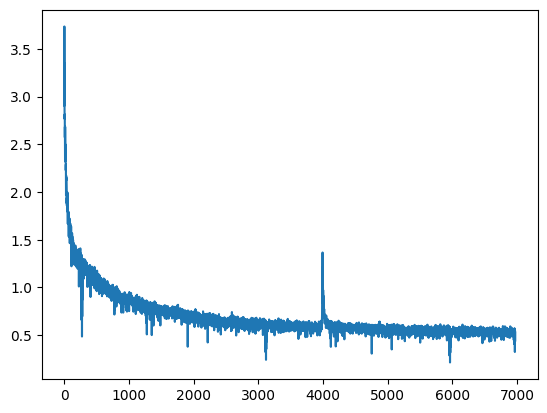

In [11]:
plt.plot(log)

In [12]:
model.save_pretrained("models/ntp_4layers")

In [46]:
model = GPT2LMHeadModel.from_pretrained("models/ntp_4layers").to(device)

In [47]:
# Replace head
model.lm_head = nn.Sequential(nn.Linear(config.n_embd, config.n_embd), nn.GELU(), nn.Linear(config.n_embd, 8*8*13)).to(device)
# Only optimize head
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [48]:
board_log = []

for epoch in range(1, 1+epochs):
    board_log = board_train(model, optimizer, X_train, Y_batched, verbose=True, log=board_log)

|  2844/ 2844 batches | ms/batch 46.65 | loss  0.42 | piece acc  0.87 | board acc  0.12  


KeyboardInterrupt: 

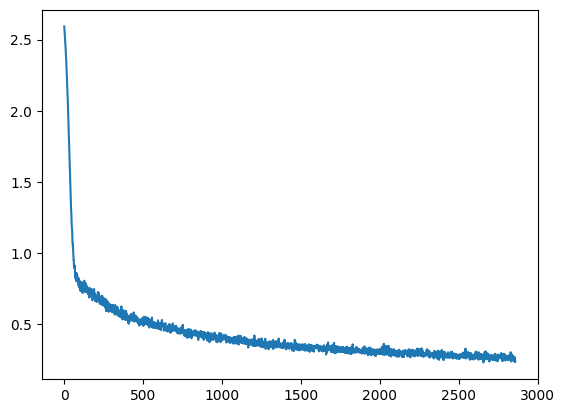

In [49]:
plt.plot([e["loss"] for e in board_log])

In [50]:
model.save_pretrained("models/board_from_ntp")

In [51]:
model = GPT2LMHeadModel.from_pretrained("models/4_layer", ignore_mismatched_sizes=True).to(device)

Some weights of the model checkpoint at models/4_layer were not used when initializing GPT2LMHeadModel: ['lm_head.bias']
- This IS expected if you are initializing GPT2LMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2LMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at models/4_layer and are newly initialized because the shapes did not match:
- lm_head.weight: found shape torch.Size([832, 256]) in the checkpoint and torch.Size([31, 256]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [52]:
# Replace head
model.lm_head = nn.Sequential(nn.Linear(config.n_embd, config.n_embd), nn.GELU(), nn.Linear(config.n_embd, config.vocab_size)).to(device)
# Only optimize head
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [53]:
ntp_log = []

for epoch in range(1, 1+epochs):
    ntp_log = ntp_train(model, optimizer, X_train, verbose=True, log=ntp_log)

  0%|          | 12/2844 [00:00<02:06, 22.39it/s, loss=0.588]


KeyboardInterrupt: 